## Описание проекта
Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.
Изучить воронку продаж. Узнайть, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
Исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

### Описание данных
Каждая запись в логе — это действие пользователя, или событие.
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from scipy import stats as st
import numpy as np
import math as mth

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
events_log = pd.read_csv('/datasets/logs_exp.csv', sep='\t') #

In [4]:
events_log.head(3)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248


Данные выглядят ок. Пропусков, Nan нет. 
Нужно привести столбцы с датой/времени к типу datetime.

In [5]:
# приводим имена столбцов к единому виду - нижний регистр, пробелы внутри имени меняем на символ "_"
events_log.columns = ['event_name', 'user_id', 'event_timestamp', 'group']

In [6]:
# а что насчет дубликатов?
events_log.duplicated().sum()

413

In [7]:
# Избавляемся
events_log = events_log.drop_duplicates().reset_index(drop=True)

In [8]:
events_log.isna().sum()

event_name         0
user_id            0
event_timestamp    0
group              0
dtype: int64

Ну хоть NaN нет.

Судя по всему, время события у нас в формате unix timestamp - в секундах с 01.01.1970. Преобразуем в что-то более наглядное.

In [9]:
events_log['datetime'] = pd.to_datetime(events_log['event_timestamp'], unit='s')

In [10]:
# добавим столбец даты
events_log['date'] = events_log['datetime'].dt.date

In [11]:
events_log.head(3)

,event_name,user_id,event_timestamp,group,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25


In [12]:
events_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
event_name         243713 non-null object
user_id            243713 non-null int64
event_timestamp    243713 non-null int64
group              243713 non-null int64
datetime           243713 non-null datetime64[ns]
date               243713 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


### Вывод
Данные, в общем, неплохие. Дубликатов чуть больше 400 на 243 тысячи строк. Дата и время были в формате  unix timestamp, перевел в стандартный datetime и отдельным столбцов выделил из нее дату.

### EDA
- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период пердставлены? Найти максимальную и минимальную дату. Построить гистограмму по дате и времени. - Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определить, с какого момента данные полные и отбросить более старые. Данными за какой период времени располагаем на самом деле?
- Много ли событий и пользователей потеряли, отбросив старые данные?
- Проверить, что есть пользователи из всех трёх экспериментальных групп.

Сколько всего событий в логе?
В датафрейме 243713 записей - столько же и событий.

In [13]:
# Сколько всего пользователей в логе?
events_log['user_id'].nunique()

7551

In [14]:
# Сколько в среднем событий приходится на пользователя?
mean_events_per_user = len(events_log.index) / events_log['user_id'].nunique()
round(mean_events_per_user)

32

In [15]:
# Данными за какой период вы располагаете? Найдите минимальную дату.
events_log[events_log['event_timestamp']==events_log['event_timestamp'].min()]['date']

0    2019-07-25
Name: date, dtype: object

In [45]:
# Найдите максимальную дату.
events_log[events_log['event_timestamp']==events_log['event_timestamp'].max()]['date']

243712    2019-08-07
Name: date, dtype: object

###### Данные с 25 июля по 7 августа 2019 года.

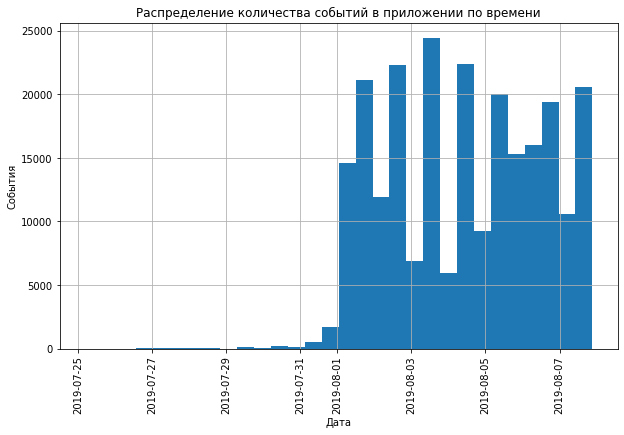

In [17]:
# Постройте гистограмму по дате и времени.
plt.xticks(rotation=90)
events_log['datetime'].hist(bins=30, figsize=(10,6));
plt.xlabel('Дата')
plt.ylabel('События')
plt.title('Распределение количества событий в приложении по времени')
#plt.xticks(rotation=90)     
plt.show()

###### Определить, с какого момента данные полные и отбросить более старые. Данными за какой период времени  располагаем на самом деле?
Судя по гистограмме, полные данные мы стали получать только начиная с 1го августа. То есть располагаем полными данными за неделю - с 1го по 7е августа 2019г.

Определить, с какого момента данные полные и отбросить более старые

In [18]:

start = pd.to_datetime("2019-07-31").date()
events_log_full_data = events_log.query('date > @start').reset_index(drop=True)

In [19]:
events_log_full_data.head(3)

,event_name,user_id,event_timestamp,group,datetime,date
0,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
1,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01


In [20]:
# Много ли событий вы потеряли, отбросив старые данные?
len(events_log.index) - len(events_log_full_data.index)

2826

In [21]:
# Много ли пользователей вы потеряли, отбросив старые данные?
events_log['user_id'].nunique() - events_log_full_data['user_id'].nunique()

17

#### Потеряли совсем немного - всего 1% событий, а для пользователей этот показатель вообще исчезающе мал. Зато у нас теперь полный и красивый датафрейм, который можно анализировать!

In [22]:
# Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.
for i in {246, 247, 248}:
    print(events_log_full_data[events_log_full_data['group']==i]['user_id'].nunique(),'в группе', i)

2537 в группе 248
2484 в группе 246
2513 в группе 247


#### Есть пользователи из всех групп и почти равное количество!

### Вывод
В нашем датафрейме 243713 событий и 7551 пользователей, что дает в среднем 32 события для каждого пользователя. Располагаем данными с 25 июля по 8 августа 2019 года. Но изучив гистограмму распределения количества событий по времени, делаем вывод, что полные данные начали приходить начиная с 1 августа, соответственно временной диапазон для изучения сужается до одной недели - с 1го по 7е августа. Присужении диапазона потеряли примерно 1% событий и всего 17 пользователей. 
Также в данных присутствуют пользователи из всех трех экспериментальных групп и почти в равной пропорции.

### Изучим воронку событий
- Какие события есть в логах, как часто они встречаются? Отсортировать события по частоте.
- Сколько пользователей совершали каждое из этих событий? Отсортировать события по числу пользователей. Посчитать долю пользователей, которые хоть раз совершали событие.
- В каком порядке происходят события? Все ли они выстраиваются в последовательную цепочку? 
- По воронке событий посчитать, какая доля пользователей проходит на следующий шаг воронки. 
- На каком шаге теряется больше всего пользователей?
- Какая доля пользователей доходит от первого события до оплаты?

In [23]:
# какие бывают события
events_log_full_data['event_name'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

##### Итого есть 5 возможных событий:
- Обучение
- Отображение основного экрана
- Отображение экрана предложения
- Отображение экрана данных карты
- Экран успешного платежа

Отсортировать события по частоте.

In [24]:

sorted_events = events_log_full_data.groupby('event_name', as_index=False)[['user_id']].count().sort_values(by='user_id', ascending=False)
sorted_events

,event_name,user_id
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Посчитать, сколько пользователей совершали каждое из этих событий. Отсортировать события по числу пользователей. 

In [25]:
sorted_events_by_user = events_log_full_data.groupby('event_name', as_index=False).agg({'user_id':'nunique'}).rename(columns={'user_id': 'users'}).sort_values(by='users', ascending=False).reset_index(drop=True)
sorted_events_by_user

,event_name,users
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Посчитать долю пользователей, которые хоть раз совершали событие.

In [26]:

sorted_events_by_user['users_share'] = sorted_events_by_user['users'] / events_log_full_data['user_id'].nunique()
sorted_events_by_user['users_share'] = sorted_events_by_user['users_share'].round(decimals=2)
sorted_events_by_user

,event_name,users,users_share
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


##### В каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? 
Собственно, отсортированные по частоте события и демонстрируют нам воронку событий:
- Отображение основного экрана
- Отображение экрана предложения
- Отображение экрана данных карты
- Экран успешного платежа

Экран обучения выбивается из этой стройной картины мира, потому что является необязательным, побочным событием. 

По воронке событий посчитать, какая доля пользователей проходит на следующий шаг воронки.

In [27]:
sorted_events_by_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
event_name     5 non-null object
users          5 non-null int64
users_share    5 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 248.0+ bytes


In [28]:
sorted_events_by_user.loc[0,'relative_users_share'] = sorted_events_by_user.loc[0, 'users'] / sorted_events_by_user.loc[0, 'users']
for i in {1,2,3}:
    sorted_events_by_user.loc[i,'relative_users_share'] = sorted_events_by_user.loc[i, 'users'] / sorted_events_by_user.loc[i-1, 'users']
    

In [46]:
sorted_events_by_user.head(4)

,event_name,users,users_share,relative_users_share
0,MainScreenAppear,7419,0.98,1.000000
1,OffersScreenAppear,4593,0.61,0.619086
2,CartScreenAppear,3734,0.50,0.812976
3,PaymentScreenSuccessful,3539,0.47,0.947777


#### На каком шаге теряется больше всего пользователей?
При переходе от главного экрана к экрану предложения. Не всех пользователей заинтересовали наши товары. Или просто раздел с "Предложениями" плохо заметен?

#### Какая доля пользователей доходит от первого события до оплаты?

In [30]:
sorted_events_by_user.loc[3, 'users'] / sorted_events_by_user.loc[0, 'users']

0.47701846610055265

48%. Это очень неплохой результат.

### Вывод

Воронка событий нашего приложения такова:
- Отображение основного экрана
- Отображение экрана предложения
- Отображение экрана данных карты
- Экран успешного платежа

Больше всего пользователей теряем при переходе от Главного экрана к Экрану предложений - почти 40%. Надо обратить на это внимание - сделать этот раздел более заметным.
Тем не менее почти половина пользователей доходит до покупки.

При  этом 2% мы теряем на стадии Главного экрана, чего не должно происходить. Возможно, у части пользователей есть проблема с запуском приложения.

###  Изучить результаты эксперимента
- Сколько пользователей в каждой экспериментальной группе?
- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверить, находят ли статистические критерии разницу между выборками 246 и 247.
- Выбрать самое популярное событие. Посчитать число пользователей, совершивших это событие в каждой из контрольных групп. Посчитать долю пользователей, совершивших это событие. Проверить, будет ли отличие между группами статистически достоверным. Проделать то же самое для всех других событий. Можно ли сказать, что разбиение на группы работает корректно?
- Аналогично поступить с группой с изменённым шрифтом. Сравнить результаты с каждой из контрольных групп в отдельности по каждому событию. Сравнить результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
- Какой уровень значимости выбран при проверке статистических гипотез выше? Посчитать, сколько проверок статистических гипотез вы сделали.

In [31]:
# Сколько пользователей в каждой экспериментальной группе?
for i in {246, 247, 248}:
    print(events_log_full_data[events_log_full_data['group']==i]['user_id'].nunique(),'в группе', i)

2537 в группе 248
2484 в группе 246
2513 в группе 247


#### Сравнение групп А1(246)  и А2(247)
Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

#### Выбрать самое популярное событие. 
##### Как мы видели выше, самое популярное событие - MainScreenAppear	

Посчитать число пользователей, совершивших это событие в каждой из контрольных групп.

In [32]:

sorted_events_by_groups = events_log_full_data.groupby(['event_name', 'group'], as_index=False).agg({'user_id':'nunique'}).rename(columns={'user_id': 'users'}).sort_values(by='users', ascending=False).reset_index(drop=True)
top_event = sorted_events_by_groups.head(3)
top_event

,event_name,group,users
0,MainScreenAppear,248,2493
1,MainScreenAppear,247,2476
2,MainScreenAppear,246,2450


Посчитать долю пользователей, совершивших это событие.

In [33]:
group_quant = events_log_full_data.groupby('group',as_index=False).agg({'user_id':'nunique'}).sort_values(by='group')
group_quant

,group,user_id
0,246,2484
1,247,2513
2,248,2537


In [34]:
group_quant[group_quant['group'] == 247]['user_id']

1    2513
Name: user_id, dtype: int64

In [35]:
top_event_share = top_event.merge(group_quant, how='left', on='group')
top_event_share = top_event_share.rename(columns={'users':'users_event','user_id':'all_users'})

In [36]:
top_event_share

,event_name,group,users_event,all_users
0,MainScreenAppear,248,2493,2537
1,MainScreenAppear,247,2476,2513
2,MainScreenAppear,246,2450,2484


In [37]:
top_event_share['share'] = top_event_share['users_event'] / top_event_share['all_users']
top_event_share

,event_name,group,users_event,all_users,share
0,MainScreenAppear,248,2493,2537,0.982657
1,MainScreenAppear,247,2476,2513,0.985277
2,MainScreenAppear,246,2450,2484,0.986312


##### Доли для события MainScreenAppear различаются на десятые доли процента.

#### Проверить, будет ли отличие между группами статистически достоверным.
Для задачи сравнения долей будем использовать z-тест.  Проверим нулевую гипотезу о равенстве пропорций событий в сегментах 246 и 247. Альтернативная гипотеза - что доли в этих сегментах различаются.

Будем сравнивать конверсии событий в воронке относительно общего числа пользователей (доли пользователей).

In [38]:
# Отображение основного экрана

# критический уровень статистической значимости - 0.5, по поправке Бонферонни - делим на число тестов
alpha = .05/20  #5
    
main_screen_users = np.array([2450, 2476])
group_users = np.array([2484, 2513])

def z_method(event_users, group_users):
    p1 = event_users[0] / group_users[0]
    p2 = event_users[1] / group_users[1]
    p_combined = (event_users[0] + event_users[1]) / (group_users[0] + group_users[1])
    z_value = (p1 - p2) / mth.sqrt(p_combined * (1 - p_combined) * (1/group_users[0] + 1/group_users[1]))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

z_method(main_screen_users, group_users)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [39]:
alpha

0.0025

У нас 4 группы - А1, А2, А1+А2, В и 4 сравнения между ними А1-А2, А1-В, А2-В, А1+А2-В. Внутри каждого сравнения - 5 проверок.
Число проверок 4х5=20 и уровень значимости надо поделить на 20 и пересчитать тест для альфа = 0.0025


#### Проделать то же самое для всех других событий

In [40]:
sorted_events_by_groups

,event_name,group,users
0,MainScreenAppear,248,2493
1,MainScreenAppear,247,2476
2,MainScreenAppear,246,2450
3,OffersScreenAppear,246,1542
4,OffersScreenAppear,248,1531
5,OffersScreenAppear,247,1520
6,CartScreenAppear,246,1266
7,CartScreenAppear,247,1238
8,CartScreenAppear,248,1230
9,PaymentScreenSuccessful,246,1200


##### Добавим немного автоматизации!

In [41]:
group_users = np.array([2484, 2513])
def groups_compare(group1, group2):
    for event in {'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial'}:
        event_users = np.array(sorted_events_by_groups.loc[(sorted_events_by_groups['event_name']==event) & 
                        (sorted_events_by_groups['group']==group1)]['users'])
        event_users = np.append(event_users, sorted_events_by_groups.loc[(sorted_events_by_groups['event_name']==event) & 
                        (sorted_events_by_groups['group']==group2)]['users'])
        print('Для события', event)
        z_method(event_users, group_users)
        print()
        
groups_compare(246, 247)

Для события PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Tutorial
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



#### Между группами 246 и 247 нет статистически значимой разницы для всех возможных событий.
Можем переходить к сравнению с результатами группы B.

#### Сравнение групп А1(246)  и В(248)

In [42]:
group_users = np.array([2476, 2537])
groups_compare(246, 248)

Для события PaymentScreenSuccessful
p-значение:  0.17480680045140473
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события OffersScreenAppear
p-значение:  0.1604943942920638
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Tutorial
p-значение:  0.7951091679879996
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события CartScreenAppear
p-значение:  0.06079138063333267
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события MainScreenAppear
p-значение:  0.03899703704754409
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



#### Сравнение групп А2(247)  и В(248)

In [43]:
group_users = np.array([2484, 2537])
groups_compare(247, 248)

Для события PaymentScreenSuccessful
p-значение:  0.9618706055054256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события OffersScreenAppear
p-значение:  0.5399231835763176
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Tutorial
p-значение:  0.6565998928450805
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события CartScreenAppear
p-значение:  0.33640451859349874
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события MainScreenAppear
p-значение:  7.727928754697189e-07
Отвергаем нулевую гипотезу: между долями есть значимая разница



Для группы А1 статистически значимой разницы с группой В не обнаружено. А вот для группы А2 для события "Отображение основного экрана" уже есть значимая разница.

##### Теперь сравним с объединенной контрольной группой.

In [44]:
group_users_AAB = np.array([2484+2513, 2537])

for event in {'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial'}:
    event_users_AAB = np.array(sorted_events_by_groups.loc[(sorted_events_by_groups['event_name']==event) & 
                        (sorted_events_by_groups['group']==246)]['users'].values[0] + sorted_events_by_groups.loc[(sorted_events_by_groups['event_name']==event) & 
                        (sorted_events_by_groups['group']==247)]['users'].values[0])
    event_users_AAB = np.append(event_users_AAB, sorted_events_by_groups.loc[(sorted_events_by_groups['event_name']==event) & 
                        (sorted_events_by_groups['group']==248)]['users'])
    print('Для события', event)
    z_method(event_users_AAB, group_users_AAB)
    print()

Для события PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Tutorial
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



А для объединенной контрольной группы снова нет статистически значимой разницы, даже и для главной страницы. Выходит, что новый шрифт все-таки не оказал влияния на поведение пользователей.

### Вывод
Группы А1(246) и А2(247) разбиты корректно, z-критерий не находит между ними разницы для всех событий.
Так же нет статистически значимой разницы между группами А1 и В, А2 и В, за исключением главного экрана, где разница есть. Но для объединенной контрольной группы А1+А2 эта разница не подтвердилась. Из чего можем сделать вывод, что новый шрифт не оказал заметного влияния на поведение клиентов. 
Менеджеры боялись зря.

### Общий вывод
В нашем предоставленных данных было 243713 событий и 7551 пользователей, в среднем 32 события для каждого пользователя. Данные были представлены с 25 июля по 8 августа 2019 года. Но по результатам анализа, полные данные начали приходить лишь начиная с 1 августа, соответственно временной диапазон для узучения сузился до одной недели - с 1го по 7е августа. При сужении диапазона потеряли примерно 1% событий и всего 17 пользователей. 

Воронка событий нашего приложения такова:
- Отображение основного экрана
- Отображение экрана предложения
- Отображение экрана данных карты
- Экран успешного платежа

Больше всего пользователей теряется при переходе от Главного экрана к Экрану предложений - почти 40%. Надо обратить на это внимание - сделать этот раздел более заметным.
При  этом 2% мы теряем на стадии Главного экрана, чего не должно происходить. Возможно, у части пользователей есть проблема с запуском приложения.
Тем не менее почти половина пользователей доходит до покупки.

Группы А1(246) и А2(247) разбиты корректно, z-критерий не нашел между ними разницы для всех событий воронки.
Так же нет статистически значимой разницы между группами А1 и В, А2 и В, за исключением главного экрана, где разница есть. Но для объединенной контрольной группы А1+А2 эта разница не подтвердилась. Из чего можем сделать вывод, что новый шрифт не оказал заметного влияния на поведение клиентов. 